In [95]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_points = 800  # Number of time points
time = np.arange(n_points)

# Split time into two regions
split_point = n_points // 4  # Middle of the time series

# Generate base binary time series using Bernoulli distribution for each region
# Region 1 (early time points)
X1 = np.random.binomial(1, 0.6, n_points//2)
X2 = np.zeros_like(X1)

# Region 2 (later time points)
X3 = np.zeros(n_points - split_point)
X4 = np.random.binomial(1, 0.7, n_points - split_point)

# Introduce causal relationships within each region
for t in range(1, len(X1)):
    # X2 is more likely to happen if X1 happened in the previous step
    X2[t] = np.random.binomial(1, 0.8 * X1[t - 1])

for t in range(1, n_points - split_point):
    # X3 is more likely to happen if X4 happened in the previous step
    X3[t] = np.random.binomial(1, 0.9 * X4[t - 1])

# Combine both processes into the same time array for plotting
# Shift time indices of X3 and X4 to the later half
X1 = [time[i] for i in range(len(X1)) if X1[i] > 0]
X2 = [time[i] + 0.1 for i in range(len(X2)) if X2[i] > 0]
X3 = [time[i + split_point] + 0.2 for i in range(len(X3)) if X3[i] > 0]
X4 = [time[i + split_point] + 0.3 for i in range(len(X4)) if X4[i] > 0]


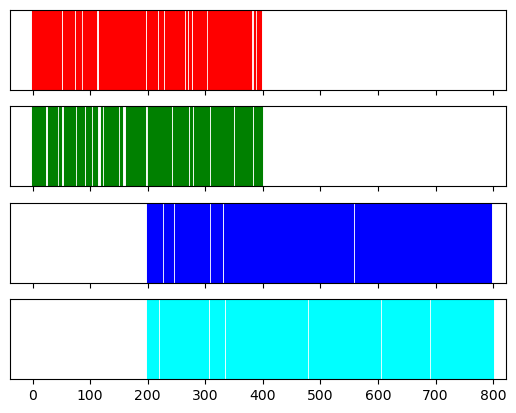

In [96]:
def _plot_tick_bars(timestamps_i, ax, color):
    for t in timestamps_i:
        ax.axvline(x=t, color = color)
    # ax.set_title(label, fontsize=20)
    ax.get_yaxis().set_visible(False)
def _plot_tick_bars_causes(timestamps_i, ax, cause):
    colors = ['red', 'green', 'blue', 'cyan']
    for idx, t in enumerate(timestamps_i):
        cause_ = torch.argmax(cause[idx]).item()
        ax.axvline(x=t, color = colors[cause_])
    ax.get_yaxis().set_visible(False)

fig, ax = plt.subplots(nrows = 4, sharex = True)

_plot_tick_bars(X1, ax[0], color = 'red')
_plot_tick_bars(X2, ax[1], color = 'green')
_plot_tick_bars(X3, ax[2], color = 'blue')
_plot_tick_bars(X4, ax[3], color = 'cyan')

In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    device = "cuda"
else:
    torch.set_default_tensor_type("torch.FloatTensor")
    device = "cpu"
    

In [98]:
import torch 

class ProbRNN(nn.Module):
    def __init__(self, memory_size, gmm_size : int = 20):
        super().__init__()

        self.gmm_size = memory_size
        self.memory_size = memory_size
        self.linear = nn.Sequential(nn.Linear(self.memory_size, 64), nn.LayerNorm(64), nn.Tanh())
        self.lstm = nn.GRU(input_size = 64, hidden_size = 128, num_layers = 2, batch_first = True)
        self.lstm_norm = nn.LayerNorm(128)
        self.linear_mu = nn.Sequential(nn.Linear(128, self.gmm_size), nn.LayerNorm(self.gmm_size))
        self.linear_std = nn.Sequential(nn.Linear(128, self.gmm_size), nn.LayerNorm(self.gmm_size))
        self.linear_gmm_weights = nn.Sequential(nn.Linear(128, self.gmm_size), nn.LayerNorm(self.gmm_size), nn.Softmax(dim = 1))
        

    def forward(self, x):
      debug_x = x.clone()
      x = self.linear(x)
      x, _ = self.lstm(x)
      x = self.lstm_norm(x)
      mu = self.linear_mu(x)
      # print(mu)
      std = self.linear_std(x)
      std = torch.exp(std)
      gmm_weights = self.linear_gmm_weights(x)
      if torch.isnan(mu).any() or torch.isnan(std).any():
          print(mu, std, debug_x)


      mix_dist = self.build_distrib(mu, std, gmm_weights)

      new_X = self.sample(mu, std)
      log_prob = mix_dist.log_prob(new_X)

    
      return new_X, log_prob


    def build_distrib(self, mus, stds, gmm_weights):
      
      
      
      component_dist = torch.distributions.Normal(mus.T, stds.T)
      mix_weight = torch.distributions.Categorical(gmm_weights.T)
      mix_dist = torch.distributions.MixtureSameFamily(mix_weight, component_dist)
      self.mix_dist = mix_dist
      

      return mix_dist

    def sample(self, mu, std):
      size = (std.size(0),)

      X =  mu + self.mix_dist.sample(size)*std

      return X


In [99]:
# rede = ProbRNN(memory_size=10)
# sum(p.numel() for p in rede.parameters())

In [183]:
X1_ = torch.tensor(X1.copy(), dtype = torch.float32)
X2_ = torch.tensor(X2.copy(), dtype = torch.float32)
X3_ = torch.tensor(X3.copy(), dtype = torch.float32)
X4_ = torch.tensor(X4.copy(), dtype = torch.float32)
processes = [X1_, X2_, X3_, X4_]

In [184]:
class SoftmaxParameter(nn.Parameter):
    def __new__(cls, *args, **kwargs):
        return super(SoftmaxParameter, cls).__new__(cls, *args, **kwargs)

    def __init__(self, data=None, requires_grad=True):
        super(SoftmaxParameter, self).__init__()
        self.data = data
        self.requires_grad = requires_grad

    def __get__(self, instance, owner):
        
        return torch.softmax(self.data, dim=1)

class GrangerMatrixModule(nn.Module):
    def __init__(self, n_processes):
        super().__init__()
        # Use SoftmaxParameter to ensure rows always sum to 1
        self.GrangerMatrix = SoftmaxParameter(torch.empty(n_processes, n_processes), requires_grad=True)
        nn.init.normal_(self.GrangerMatrix.data, mean=1, std=0.01)


In [185]:
class GrangerMPP(nn.Module):

    def __init__(self, processes, memory_dim : int = 10):
        
        super().__init__()
        
        self.processes = processes
        self.memory_dim = memory_dim
        self.n_processes = len(self.processes)
        
        self.GrangerMatrix = GrangerMatrixModule(n_processes=self.n_processes)

        self.model = ProbRNN(self.memory_dim) 
        self.sweep_dict = self.make_sweep_dict()
        self.optimizer = torch.optim.Adam(list(self.model.parameters()) + list(self.GrangerMatrix.parameters()), lr=1e-4, weight_decay = 1e-5) 
        self.log_GrangerMatrix = []
        
    def e_step(self, i_proc, points_current_pp):
        
        """
        Return the causes for each event of the current_p
        
        """
        
        n = len(points_current_pp)
        rv = []
        in_weights = self.GrangerMatrix.GrangerMatrix[i_proc]
        in_ = in_weights
        
        for i in range(n):
            cause = F.gumbel_softmax(
                in_,
                tau = 1,
                hard = False
            )
            rv.append(cause)
        
        return rv

    def em_step(self, n_steps):
        dic = {}
        
        for i in range(self.n_processes):
            dic[i] = []
        
        for step in range(n_steps):
            self.causes = []
            for i_proc in range(self.n_processes):
                rv = self.e_step(
                    i_proc,
                    self.processes[i_proc]
                )
                self.causes.append(rv)
            
            
            for i_proc in range(self.n_processes):
                
                batch_list = self.get_batch_list(i_proc)
                self.batch_size = 32
                dataloader = self.make_dl(batch_list = batch_list, batch_size = self.batch_size, drop_last = False)
                self.dataloader = dataloader
                
                for _, (X, cause_rank) in enumerate(dataloader):

                    reg_term = len(self.processes[i_proc])
                    loss = self.m_step(i_proc, X, cause_rank) 
                    dic[i_proc].append(loss)
                
                if (step + 1) % 5 == 0 or step == 0:
                    print(f'Step: {step + 1}, Model: {i_proc}, Loss: {loss}')
        
        return dic

    def m_step(self, i_proc, X, cause_rank):

        model = self.model
        self.optimizer.zero_grad()
        
        z, loss = model(X)
        loss = -1*loss.sum(axis = 1)
        loss_rnn = (loss * cause_rank).sum()/self.batch_size #+ mpp.GrangerMatrix.norm(p=2)
       
        
        if not (torch.isnan(loss_rnn) | torch.isinf(loss_rnn)):

            
            loss_rnn.backward(retain_graph = True)
            
            self.optimizer.step()
            self.log_GrangerMatrix.append(self.GrangerMatrix.GrangerMatrix.clone().detach())
            
        
        else:
            print(f'NaN found in epoch: {step}')    

        return loss_rnn.item()

    def make_sweep_dict(self):
        
        dic = {}
        for i in range(self.n_processes):
            target = processes[i]
            dic[i] = {}
            for j in range(self.n_processes):
                cause = self.processes[j]
                dic[i][j] = self.sweep(target, cause)
        return dic


    def sweep(self, pa, pc):
        events = []
        pa_indices = []  
    
        
        for i, ia in enumerate(pa):
            events.append((ia, 'a'))
            pa_indices.append(i)  
    
        for ic in pc:
            events.append((ic, 'c'))
    
        lim = self.memory_dim
    
        events.sort()
        mem = []
        ret = []
        indices = []  # List to store indices relative to pa
    
        pa_idx_counter = 0  # Counter to track which index in pa we are at
    
        for t, e in events:
            if e == 'c':
                if len(mem) >= lim:
                    mem.pop(0)
                mem.append(t)
    
            if e == 'a':
                # Memory is not full yet
                if len(mem) < lim:
                    pa_idx_counter += 1  # Move to the next pa index
                    continue
                # Retrieve deltas from this time to the cause times
                pp = [t - tc for tc in mem]
                ret.append(pp)
                indices.append(pa_indices[pa_idx_counter])  # Save index relative to pa
                pa_idx_counter += 1  # Move to the next pa index
    
        return torch.tensor(ret, dtype=torch.float), indices

    def get_batch_list(self, i_proc):
    
      batch_list = []
      dic = self.sweep_dict
      causes = self.causes[i_proc]
      
      for idx in range(len(causes)):
          full = True
          n_causes = causes[idx] 
          cur = []
        #   print(n_causes)
          for idx_j, cause_rank in enumerate(n_causes):
            if idx < dic[i_proc][idx_j][1][0]: 
                full =  False
                new_causes = n_causes.detach().clone()
                new_causes[idx_j] = 0.0
                new_causes[i_proc] = 1.0
                self.causes[i_proc][idx] = new_causes
            else:
                where_in_tensor = dic[i_proc][idx_j][1].index(idx)
                app = (dic[i_proc][idx_j][0][where_in_tensor], cause_rank.clone())
                cur.append(app)
          
          # Add current timestamp to batch_list only if all other processes are already alive
          if full:
            batch_list.extend(cur)
        
      #print('IDX', foo)
      #return Exception()
      return batch_list
    
    def make_dl(self, batch_list : list, batch_size : int, drop_last : bool):
    
      dataloader = DataLoader(batch_list, batch_size = batch_size, drop_last = drop_last, shuffle = False)
    
      return dataloader

In [186]:
mpp = GrangerMPP(processes, memory_dim = 10)
l = mpp.em_step(n_steps = 200)

Step: 1, Model: 0, Loss: 5.646770000457764
Step: 1, Model: 1, Loss: 5.755889892578125
Step: 1, Model: 2, Loss: 3.350285530090332
Step: 1, Model: 3, Loss: 5.527446746826172
Step: 5, Model: 0, Loss: 6.339826583862305
Step: 5, Model: 1, Loss: 5.491352081298828
Step: 5, Model: 2, Loss: 5.937686920166016
Step: 5, Model: 3, Loss: 5.299215316772461
Step: 10, Model: 0, Loss: 5.60231876373291
Step: 10, Model: 1, Loss: 4.333102226257324
Step: 10, Model: 2, Loss: 2.5074806213378906
Step: 10, Model: 3, Loss: 5.126222610473633
Step: 15, Model: 0, Loss: 5.280147552490234
Step: 15, Model: 1, Loss: 4.0121307373046875
Step: 15, Model: 2, Loss: 2.5973005294799805
Step: 15, Model: 3, Loss: 3.925525188446045
Step: 20, Model: 0, Loss: 4.754701137542725
Step: 20, Model: 1, Loss: 3.3403618335723877
Step: 20, Model: 2, Loss: 2.8119518756866455
Step: 20, Model: 3, Loss: 3.5676381587982178
Step: 25, Model: 0, Loss: 4.00587272644043
Step: 25, Model: 1, Loss: 4.782758712768555
Step: 25, Model: 2, Loss: 2.32631587

In [153]:
# colors = ['red', 'green', 'blue', 'cyan']
# for i in range(len(colors)):
#     plt.plot(l[i], color = colors[i])

# t = [len(l[i]) for i in range(len(colors))]

# print(f'Len of losses: {t}')

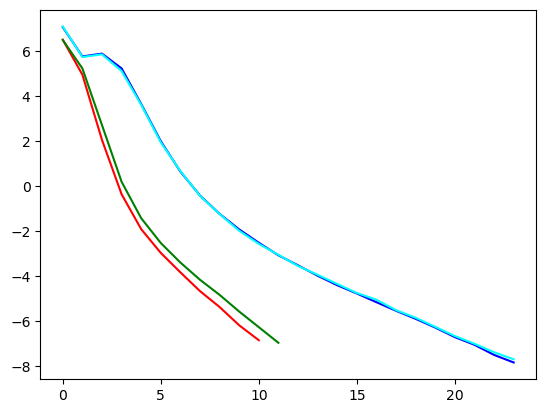

In [154]:
colors = ['red', 'green', 'blue', 'cyan']
final = []
for proc in range(len(colors)):
    proc_size = len(processes[proc])
    loss_size = len(l[proc])
    temp = [ sum(l[proc][i:i + proc_size])/proc_size for i in range(0, loss_size - proc_size, proc_size)]
    final.append(temp)

for i in range(len(colors)):
    plt.plot(final[i], color = colors[i])

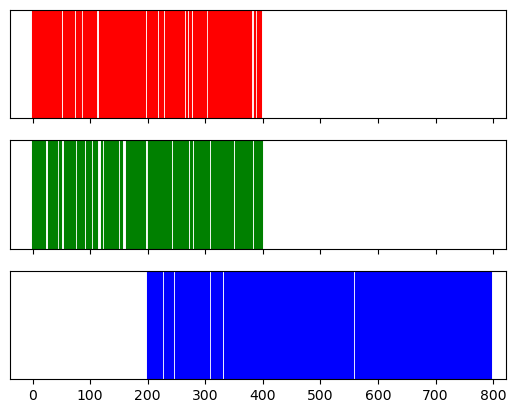

In [140]:
fig, ax = plt.subplots(nrows = 3, sharex = True)

_plot_tick_bars(X1, ax[0], color = 'red')
_plot_tick_bars(X2, ax[1], color = 'green')
_plot_tick_bars(X3, ax[2], color = 'blue')

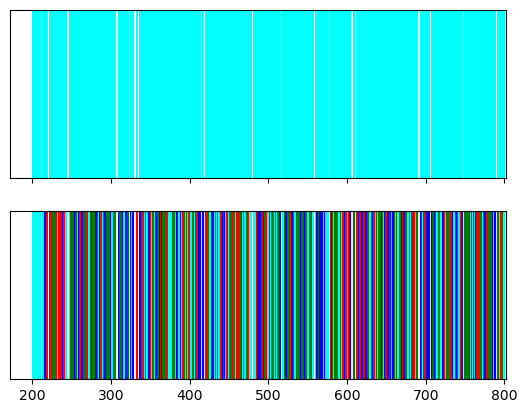

In [144]:
fig, ax = plt.subplots(nrows=2, sharex = True)
colors = ['red', 'green', 'blue', 'cyan']
idx = 3
proc_to_plot = processes[idx].detach().cpu().numpy()
_plot_tick_bars(proc_to_plot, ax[0], color = colors[idx])
_plot_tick_bars_causes(proc_to_plot, ax[1], cause = mpp.causes[idx])


In [117]:
# processes = [X2_, X3_, X1_, X4_]

In [182]:
s = [i.argmax().item() for i in mpp.causes[0]]
s = torch.tensor(s)
s.unique(return_counts = True)

(tensor([0, 1, 2, 3]), tensor([156,  25,  32,  22]))

In [177]:
mpp.GrangerMatrix.GrangerMatrix.detach().cpu().numpy()

array([[0.6796363 , 1.4165868 , 1.2694896 , 0.6464442 ],
       [0.69710714, 1.3437483 , 1.2433563 , 0.7119026 ],
       [0.37579626, 1.7816559 , 1.5037713 , 0.29113004],
       [0.3201722 , 1.8713473 , 1.4703506 , 0.26225817]], dtype=float32)

In [160]:
mpp.sweep_dict[2][0][0][0]

tensor([21.2000, 20.2000, 17.2000, 14.2000, 13.2000, 12.2000, 11.2000,  7.2000,
         6.2000,  0.2000])

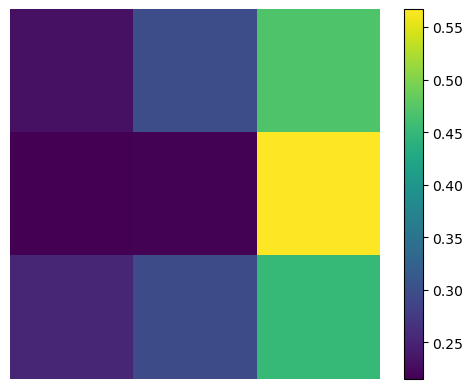

In [284]:
X = mpp.GrangerMatrix.detach().cpu().numpy()
X = (X.T/X.sum(axis = 1)).T
plt.imshow(X)
plt.axis('off')
plt.colorbar()

In [93]:
mpp.GrangerMatrix.detach().cpu().numpy()

array([[ 0.996765  , -0.00235457,  0.00471825],
       [ 0.33289954,  0.33716395,  0.3306691 ],
       [ 0.42307693,  0.01438018,  0.56958264]], dtype=float32)

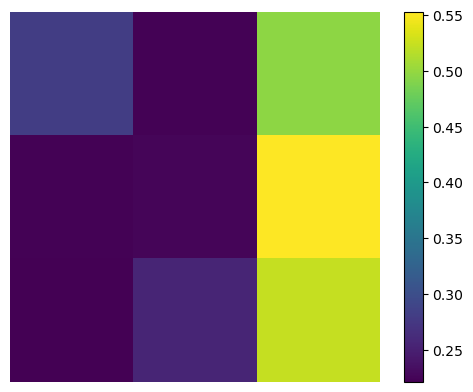

In [38]:
s = mpp.GrangerMatrix.softmax(dim = 1).detach().cpu().numpy()

plt.imshow(s)
plt.axis('off')
plt.colorbar()